<a id="top"></a>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using pycaret</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [github:pycaret](https://github.com/pycaret)
- [TWS: PyCaret 2.2 is here — What’s new?](https://towardsdatascience.com/pycaret-2-2-is-here-whats-new-ad7612ca63b)
- [pycaret-demo-queens/PyCaret 2 Classification.ipynb](https://github.com/pycaret/pycaret-demo-queens/blob/main/PyCaret%202%20Classification.ipynb)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()

from tqdm import tqdm_notebook as tqdm

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

# special
import pycaret

%load_ext watermark
%watermark -iv

seaborn   : 0.11.0
json      : 2.0.9
matplotlib: 3.3.3
pycaret   : 2.2.2
autopep8  : 1.5.4
pandas    : 1.1.5
numpy     : 1.19.4
sys       : 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]



In [3]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install ipywidgets
#     !pip install pycaret-nightly[full]
    !/opt/conda-environments/rapids-stable/bin/python -m pip install --upgrade pycaret
    !pip install tune-sklearn
    !jupyter nbextension enable --py widgetsnbextension

    from pycaret.utils import enable_colab
    enable_colab()

    
    # uninstall lightgbm CPU
    pip uninstall lightgbm -y
    # install lightgbm GPU with gpu
    pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

    print('Environment: Google Colab')

<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [4]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

In [44]:
def compare_new_models(name,desc,mean_row,df_eval=None,sort='Recall',show=True):
    """Create dataframe from output of pycaret new model.
    Parameters
    -----------
    name: str
        Name of the model. eg. xgboost
    desc: str
        Description of the model. e.g tuned,calibrated
    mean_row: str
        The line copied from jupyter notebook output from
        pycaret new model. Note that fields are separated
        with tabs.
        e.g.
        Mean	0.9992	0.9663	0.7214	0.8299	0.7679	0.7675
    df_eval: Pandas Dataframe
        Template pandas dataframe
    sort: str
       One of following string: Accuracy, AUC, Recall, Precision
                                F1, Kappa
    
    
    Returns:
       Pandas Dataframe.

    """
    mean_row_lst = mean_row.split('\t')
    assert len(mean_row_lst) == 9
    
    if not isinstance(df_eval, pd.DataFrame):
        df_eval = pd.DataFrame({'Model': [],
                                'Description':[],
                                'Accuracy':[],
                                'AUC':[],
                                'Recall':[],
                                'Precision':[],
                                'F1':[],
                                'Kappa':[],
                                'MCC': [],
                                'LogLoss': []
                               })

    acc,auc,rec,pre,f1,kap,mcc,logloss = mean_row.split('\t')[1:]
    row = [name,desc,acc,auc,rec,pre,f1,kap,mcc,logloss]

    df_eval.loc[len(df_eval)] = row
    df_eval = df_eval.drop_duplicates()\
                     .sort_values(sort,ascending=False)
    df_eval.index = range(len(df_eval))
    
    df_style = (df_eval.style.apply(lambda ser:
                ['background: tomato'
                 if ser.name == sort else ''
                 for _ in ser]))
    
    if show:
        display(df_style)
    
    return df_eval

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [5]:
path_data_train = '../data/processed/train_cleaned.csv'
path_data_test = '../data/processed/test_cleaned.csv'

if ENV_COLAB:
    path_data_train = 'https://github.com/bhishanpdl/Datasets/processed/master/Projects/Telco_Customer_Churn/processed/train_cleaned.csv'
    path_data_test = 'https://github.com/bhishanpdl/Datasets/processed/master/Projects/Telco_Customer_Churn/processed/test_cleaned.csv'

In [6]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 39)
(1409, 39)


,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,NoSeniorCitizen_Contract_Month-to-month,PaymentMethod0_Contract_Month-to-month0,InternetService_Fiber optic,StreamingTV_NoInternetService,No_OB_DP_TS,TotalServices,SenCit_Dependents,Partner_Dependents,SenCit_Partner,SenCit_Contract,SenCit_TechSupport,SenCit_PayMeth,Contract_mean_totCharges,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat
0,0,0,1,0,36,1,2,1,2,2,2,2,0,2,2,1,1,106.05,3834.40,0,1,0,0,0,1,1,2,0,1,1,2,2,1,3683.643192,150.756808,66.703657,39.346343,3,0
1,1,0,0,0,10,1,0,0,2,0,0,2,2,0,0,0,1,62.25,612.95,0,0,1,0,1,1,1,1,0,0,0,0,2,1,1370.923131,-757.973131,66.703657,-4.453657,0,0
5632,0,0,1,1,68,1,2,1,0,2,0,2,2,2,2,1,1,103.75,7039.45,0,1,0,0,0,1,1,2,1,2,1,2,2,1,3683.643192,3355.806808,66.703657,37.046343,5,0
5633,1,0,0,0,69,1,2,2,1,1,1,1,1,1,2,0,1,23.95,1713.10,0,1,0,0,1,0,1,7,0,0,0,2,1,1,3683.643192,-1970.543192,66.703657,-42.753657,5,0


In [7]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [8]:
# check for nans
df_train.isna().sum().sum()

0

<a id="" ></a>

<h1>  Modelling Pycaret </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
import pycaret
import pycaret.classification as pyc

<a id="" ></a>

<h1>  Pycaret Setup</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.setup(
    data: pandas.core.frame.DataFrame,
    target: str,
    train_size                    = 0.7,
    test_data                     = None,
    preprocess                    = True,
    imputation_type               = 'simple',
    iterative_imputation_iters    = 5,
    categorical_features          = None,
    categorical_imputation        = 'constant',
    categorical_iterative_imputer = 'lightgbm',
    ordinal_features              = None,
    high_cardinality_features     = None,
    high_cardinality_method       = 'frequency',
    numeric_features              = None,
    numeric_imputation            = 'mean',
    numeric_iterative_imputer     = 'lightgbm',
    date_features                 = None,
    ignore_features               = None,
    normalize                     = False,
    normalize_method              = 'zscore',
    transformation                = False,
    transformation_method         = 'yeo-johnson',
    handle_unknown_categorical    = True,
    unknown_categorical_method    = 'least_frequent',
    pca                           = False,
    pca_method                    = 'linear',
    pca_components                = None,
    ignore_low_variance           = False,
    combine_rare_levels           = False,
    rare_level_threshold          = 0.1,
    bin_numeric_features          = None,
    remove_outliers               = False,
    outliers_threshold            = 0.05,
    remove_multicollinearity      = False,
    multicollinearity_threshold   = 0.9,
    remove_perfect_collinearity   = True,
    create_clusters               = False,
    cluster_iter                  = 20,
    polynomial_features           = False,
    polynomial_degree             = 2,
    trigonometry_features         = False,
    polynomial_threshold          = 0.1,
    group_features                = None,
    group_names                   = None,
    feature_selection             = False,
    feature_selection_threshold   = 0.8,
    feature_selection_method      = 'classic',
    feature_interaction           = False,
    feature_ratio                 = False,
    interaction_threshold         = 0.01,
    fix_imbalance                 = False,
    fix_imbalance_method          = None,
    data_split_shuffle            = True,
    data_split_stratify           = False,
    fold_strategy                 = 'stratifiedkfold',
    fold                          = 10,
    fold_shuffle                  = False,
    fold_groups                   = None,
    n_jobs                        = -1,
    use_gpu                       = False,
    custom_pipeline               = None,
    html                          = True,
    session_id                    = None,
    log_experiment                = False,
    experiment_name               = None,
    log_plots                     = False,
    log_profile                   = False,
    log_data                      = False,
    silent                        = False,
    verbose                       = True,
    profile                       = False,
    profile_kwargs                = None,
)

```

In [11]:
df_train.shape

(5634, 39)

In [20]:
show_methods(pyc)

,0,1,2,3
0,Any,calibrate_model,interpret_model,pull
1,Dict,compare_models,io,pycaret
2,Display,create_model,is_in_colab,remove_metric
3,List,deploy_model,load_config,save_config
4,MLUsecase,enable_colab,load_model,save_model
5,Optional,ensemble_model,models,set_config
6,Tuple,evaluate_model,np,setup
7,Union,finalize_model,optimize_threshold,stack_models
8,add_metric,get_config,pd,traceback
9,automl,get_logs,plot_model,tune_model


In [69]:
USE_GPU = False
if ENV_COLAB:
    USE_GPU = True

In [18]:
exp = pyc.setup(df_train,'Churn',
                train_size=0.8,
                session_id=SEED,
                use_gpu=USE_GPU,
                preprocess = True,
                categorical_features = None,
                ordinal_features = None,
                high_cardinality_features = None,
                numeric_features = None,
                date_features = None,
                ignore_features = None,
                normalize = False,
                data_split_stratify = True,
                silent=True,
                profile=False,
                use_gpu=False,
                )

# use silent = True to check inferred datatypes
# then assign numeric and categorical features yourself.
#
# if sampling = False, 100% of data is used and its too slow
# if sampling = True, we need to enter number eg. 0.3 ourself.

"""
Here, we have data < 25k rows, so I have chosen not to use sampling.

""";

,Description,Value
0,session_id,100
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 39)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
pyc.models(internal=True)[['Name', 'GPU Enabled']]

<a id="" ></a>

<h1>  Comparing Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>



Comparing All Models
- compare using stratified cross validation for metric evaluation.
- shows average metrics for score grid for 10 fold cross-validation
- default sorting is `accuracy`


```python
pyc.compare_models(
    include          = None,
    exclude          = None,
    fold             = None,
    round            = 4,
    cross_validation = True,
    sort             = 'Accuracy',
    n_select         = 1,
    budget_time      = None,
    turbo            = True,
    errors           = 'ignore',
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
) 
```


In [22]:
# pyc.compare_models?

In [24]:
pyc.get_metrics().index

Index(['acc', 'auc', 'recall', 'precision', 'f1', 'kappa', 'mcc'], dtype='object', name='ID')

In [26]:
# add Log Loss metric in pycaret
from sklearn.metrics import log_loss
pyc.add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False)

Name                                                        LogLoss
Display Name                                                LogLoss
Score Function                <function log_loss at 0x7fb10a7ecf70>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

In [27]:
best = pyc.compare_models(sort = 'Recall',fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
nb,Naive Bayes,0.7069,0.8243,0.8345,0.4722,0.6027,0.3983,0.4389,10.1234,0.0440
qda,Quadratic Discriminant Analysis,0.6102,0.6244,0.6548,0.3697,0.4717,0.2001,0.2210,13.4642,0.0500
lda,Linear Discriminant Analysis,0.8107,0.8455,0.5493,0.6780,0.6067,0.4839,0.4887,6.5368,0.0520
gbc,Gradient Boosting Classifier,0.8123,0.8496,0.5418,0.6861,0.6053,0.4843,0.4903,6.4831,0.4760
ada,Ada Boost Classifier,0.8107,0.8498,0.5402,0.6840,0.6028,0.4808,0.4872,6.5368,0.1580
lr,Logistic Regression,0.8063,0.8507,0.5376,0.6684,0.5957,0.4703,0.4753,6.6900,0.8960
lightgbm,Light Gradient Boosting Machine,0.7959,0.8345,0.5326,0.6401,0.5808,0.4475,0.4512,7.0502,0.3560
catboost,CatBoost Classifier,0.8028,0.8437,0.5318,0.6612,0.5888,0.4611,0.4663,6.8127,3.2980
xgboost,Extreme Gradient Boosting,0.7854,0.8250,0.5301,0.6106,0.5672,0.4256,0.4276,7.4104,1.0260
rf,Random Forest Classifier,0.7972,0.8258,0.5109,0.6512,0.5723,0.4419,0.4477,7.0041,0.3160


<a id="" ></a>

<h1>  Create Models </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Estimator                   Abbreviated String     Original Implementation 
---------                   ------------------     -------------------------------
Logistic Regression         'lr'                   linear_model.LogisticRegression
K Nearest Neighbour         'knn'                  neighbors.KNeighborsClassifier
Naives Bayes                'nb'                   naive_bayes.GaussianNB
Decision Tree               'dt'                   tree.DecisionTreeClassifier
SVM (Linear)                'svm'                  linear_model.SGDClassifier
SVM (RBF)                   'rbfsvm'               svm.SVC
Gaussian Process            'gpc'                  gaussian_process.GPC
Multi Level Perceptron      'mlp'                  neural_network.MLPClassifier
Ridge Classifier            'ridge'                linear_model.RidgeClassifier
Random Forest               'rf'                   ensemble.RandomForestClassifier
Quadratic Disc. Analysis    'qda'                  discriminant_analysis.QDA
AdaBoost                    'ada'                  ensemble.AdaBoostClassifier
Gradient Boosting           'gbc'                  ensemble.GradientBoostingClassifier
Linear Disc. Analysis       'lda'                  discriminant_analysis.LDA
Extra Trees Classifier      'et'                   ensemble.ExtraTreesClassifier
Extreme Gradient Boosting   'xgboost'              xgboost.readthedocs.io
Light Gradient Boosting     'lightgbm'             github.com/microsoft/LightGBM
CatBoost Classifier         'catboost'             https://catboost.ai
```

```python
pyc.create_model(
    estimator,
    fold             = None,
    round            = 4,
    cross_validation = True,
    fit_kwargs       = None,
    groups           = None,
    verbose          = True,
    **kwargs,
)
```

In [50]:
lr = pyc.create_model('lr',verbose=False)

mean_row = "Mean	0.8056	0.8491	0.5318	0.6699	0.5922	0.4669	0.4727	6.7131"
df_eval = compare_new_models('lr','default',mean_row,sort='Recall',df_eval=None)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131


In [51]:
xgb = pyc.create_model('xgboost',verbose=False)

mean_row = "Mean	0.7886	0.8265	0.5185	0.6217	0.5651	0.4270	0.4303	7.3030"
df_eval = compare_new_models('xgb','default',mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
1,xgb,default,0.7886,0.8265,0.5185,0.6217,0.5651,0.4270,0.4303,7.3030


In [52]:
lgb = pyc.create_model('lightgbm',verbose=False)

mean_row = "Mean	0.7928	0.8356	0.5277	0.6313	0.5742	0.4389	0.4424	7.1574"
df_eval = compare_new_models('lgb','default',mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
1,lgb,default,0.7928,0.8356,0.5277,0.6313,0.5742,0.4389,0.4424,7.1574
2,xgb,default,0.7886,0.8265,0.5185,0.6217,0.5651,0.4270,0.4303,7.3030


In [54]:
nb = pyc.create_model('nb',verbose=False)

mean_row = "Mean	0.7060	0.8241	0.8336	0.4712	0.6016	0.3967	0.4373	10.1541"
df_eval = compare_new_models('nb','default',mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.7060,0.8241,0.8336,0.4712,0.6016,0.3967,0.4373,10.1541
1,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
2,lgb,default,0.7928,0.8356,0.5277,0.6313,0.5742,0.4389,0.4424,7.1574
3,xgb,default,0.7886,0.8265,0.5185,0.6217,0.5651,0.4270,0.4303,7.3030


<a id="" ></a>

<h1>  Hyperparameter Tuning</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.tune_model(
    estimator,
    fold                     = None,
    round                    = 4,
    n_iter                   = 10,
    custom_grid              = None,
    optimize                 = 'Accuracy',
    custom_scorer            = None,
    search_library           = 'scikit-learn', # 'scikit-optimize', 'tune-sklearn','optuna'
    search_algorithm         = None, # 'scikit-learn', 'scikit-optimize', 'tune-sklearn', 'optuna'
    early_stopping           = False, # 'asha','hyperband','median' 
    early_stopping_max_iters = 10,
    choose_better            = False,
    fit_kwargs               = None,
    groups                   = None,
    return_tuner             = False,
    verbose                  = True,
    tuner_verbose            = True,
    **kwargs,
)
```

In [57]:
nb

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
nb_tuned = pyc.tune_model(lr,fold=5,optimize='Recall',
                          search_library='scikit-optimize')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7727,0.8619,0.7950,0.5491,0.6496,0.4896,0.5080,7.8499
1,0.7129,0.8245,0.7750,0.4757,0.5895,0.3876,0.4150,9.9176
2,0.7758,0.8690,0.8201,0.5521,0.6599,0.5021,0.5239,7.7436
3,0.7403,0.8370,0.8033,0.5066,0.6214,0.4388,0.4658,8.9703
4,0.7691,0.8562,0.8033,0.5439,0.6486,0.4861,0.5066,7.9736
Mean,0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
SD,0.0242,0.0165,0.0147,0.0298,0.0256,0.0425,0.0394,0.8370


In [88]:
lr_tuned = pyc.tune_model(lr,fold=5,optimize='Recall',
            search_library='tune-sklearn',n_iter=100, verbose=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.7716,0.8587,0.8117,0.5465,0.6532,0.4925,0.5139,7.8882
1,0.7129,0.8246,0.7750,0.4757,0.5895,0.3876,0.4150,9.9176
2,0.7747,0.8689,0.8201,0.5506,0.6588,0.5002,0.5223,7.7819
3,0.7425,0.8341,0.8159,0.5091,0.6270,0.4460,0.4750,8.8936
4,0.7680,0.8559,0.8033,0.5424,0.6476,0.4842,0.5050,8.0119
Mean,0.7539,0.8484,0.8052,0.5249,0.6352,0.4621,0.4862,8.4986
SD,0.0235,0.0165,0.0161,0.0286,0.0252,0.0416,0.0390,0.8115


In [65]:
mean_row = ""
desc = 'tuned,tune-sklearn,n_iter=100'
df_eval = compare_new_models('nb',desc,mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.7060,0.8241,0.8336,0.4712,0.6016,0.3967,0.4373,10.1541
1,lr,"tuned,tune-sklearn,n_iter=100",0.7551,0.8488,0.8044,0.5262,0.6360,0.4636,0.4874,8.4603
2,lr,"tuned,tune-sklearn",0.7531,0.8501,0.8027,0.5238,0.6336,0.4599,0.4838,8.5293
3,lr,tuned,0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
4,lr,"tuned,scikit-optimize",0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
5,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
6,lgb,default,0.7928,0.8356,0.5277,0.6313,0.5742,0.4389,0.4424,7.1574
7,xgb,default,0.7886,0.8265,0.5185,0.6217,0.5651,0.4270,0.4303,7.3030


In [90]:
model_best = nb_tuned


LogisticRegression(C=2.039, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```
Name                        Abbreviated String     
---------                   ------------------ 
Area Under the Curve         'auc'              
Discrimination Threshold     'threshold'
Precision Recall Curve       'pr'
Confusion Matrix             'confusion_matrix'
Class Prediction Error       'error'
Classification Report        'class_report'
Decision Boundary            'boundary'
Recursive Feat. Selection    'rfe' 
Learning Curve               'learning'
Manifold Learning            'manifold'
Calibration Curve            'calibration'
Validation Curve             'vc' 
Dimension Learning           'dimension'
Feature Importance           'feature'
Model Hyperparameter         'parameter'
```

```python
pyc.plot_model(
    estimator,
    plot           = 'auc',
    scale          = 1,
    save           = False,
    fold           = None,
    fit_kwargs     = None,
    groups         = None,
    use_train_data = False,
    verbose        = True,
)
```

In [76]:
# pyc.plot_model?

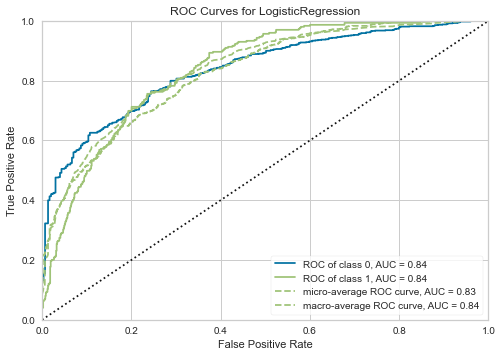

In [91]:
# AUC-ROC plot
pyc.plot_model(model_best_lr, plot = 'auc')

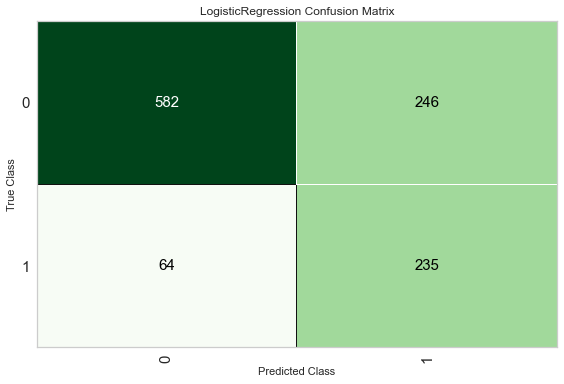

In [92]:
# confusion matrix
pyc.plot_model(model_best_lr, plot = 'confusion_matrix')

In [93]:
# evaluate model
pyc.evaluate_model(model_best_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

<a id="" ></a>

<h1>  Model Calibration</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.calibrate_model(
    estimator,
    method     = 'sigmoid',
    fold       = None,
    round      = 4,
    fit_kwargs = None,
    groups     = None,
    verbose    = True,
)
```

In [80]:
# pyc.calibrate_model?

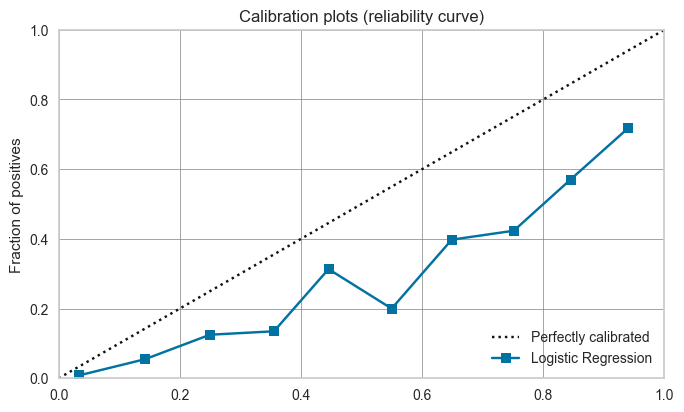

In [94]:
pyc.plot_model(model_best_lr, plot='calibration')

In [95]:
lr_tuned_calibrated = pyc.calibrate_model(model_best_lr,fold=5,
                                            method='sigmoid')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8104,0.8614,0.5356,0.6809,0.5995,0.4777,0.4836,6.5479
1,0.7905,0.8246,0.5125,0.6308,0.5655,0.4294,0.4334,7.2371
2,0.8269,0.8700,0.5607,0.7243,0.6321,0.5213,0.5286,5.9801
3,0.7936,0.8373,0.5105,0.6387,0.5674,0.4341,0.4388,7.1302
4,0.8135,0.8564,0.5146,0.7029,0.5942,0.4769,0.4867,6.4401
Mean,0.8070,0.8500,0.5268,0.6755,0.5918,0.4679,0.4742,6.6671
SD,0.0134,0.0166,0.0192,0.0361,0.0244,0.0336,0.0350,0.4641


In [96]:
mean_row = "Mean	0.8070	0.8500	0.5268	0.6755	0.5918	0.4679	0.4742	6.6671"
desc = 'tuned+calibrated'
df_eval = compare_new_models('lr',desc,mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.7060,0.8241,0.8336,0.4712,0.6016,0.3967,0.4373,10.1541
1,lr,"tuned,tune-sklearn,n_iter=100",0.7551,0.8488,0.8044,0.5262,0.6360,0.4636,0.4874,8.4603
2,lr,"tuned,tune-sklearn",0.7531,0.8501,0.8027,0.5238,0.6336,0.4599,0.4838,8.5293
3,lr,tuned,0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
4,lr,"tuned,scikit-optimize",0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
5,lr,"tuned,custom_grid",0.8063,0.8498,0.5351,0.6709,0.5947,0.4696,0.4752,6.6900
6,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
7,lgb,default,0.7928,0.8356,0.5277,0.6313,0.5742,0.4389,0.4424,7.1574
8,lr,"tuned,tune-sklearn,n_iter=1000,early_stopping_max_iters=20",0.8041,0.8500,0.5276,0.6664,0.5887,0.4623,0.4680,6.7667
9,lr,tuned+calibrated,0.8070,0.8500,0.5268,0.6755,0.5918,0.4679,0.4742,6.6671


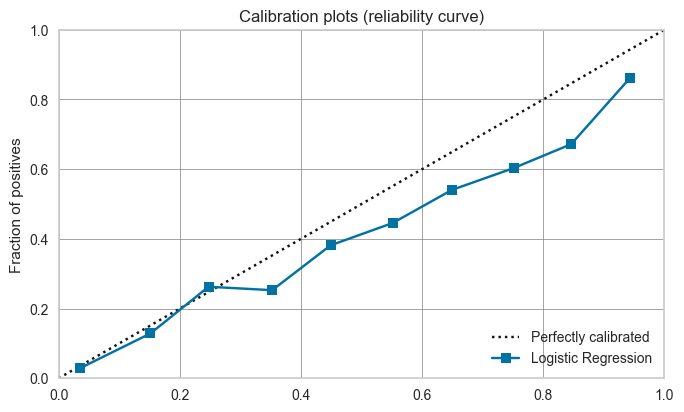

In [84]:
pyc.plot_model(lr_tuned_calibrated, plot='calibration')

In [97]:
lr_tuned_calibrated_iso = pyc.calibrate_model(model_best_lr,
                            fold=5, method='isotonic')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss
0,0.8071,0.8600,0.5063,0.6836,0.5817,0.4600,0.4687,6.6627
1,0.7905,0.8246,0.5000,0.6349,0.5594,0.4245,0.4297,7.2371
2,0.8302,0.8703,0.5314,0.7560,0.6241,0.5187,0.5321,5.8651
3,0.7936,0.8360,0.5105,0.6387,0.5674,0.4341,0.4388,7.1302
4,0.8147,0.8557,0.5439,0.6915,0.6089,0.4897,0.4958,6.4018
Mean,0.8072,0.8493,0.5184,0.6809,0.5883,0.4654,0.4730,6.6594
SD,0.0145,0.0166,0.0165,0.0439,0.0246,0.0350,0.0376,0.5005


In [98]:
mean_row = "Mean	0.8072	0.8493	0.5184	0.6809	0.5883	0.4654	0.4730	6.6594"
desc = 'tuned+calibrated_iso'
df_eval = compare_new_models('lr',desc,mean_row,sort='Recall',df_eval=df_eval)

,Model,Description,Accuracy,AUC,Recall,Precision,F1,Kappa,MCC,LogLoss
0,nb,default,0.7060,0.8241,0.8336,0.4712,0.6016,0.3967,0.4373,10.1541
1,lr,"tuned,tune-sklearn,n_iter=100",0.7551,0.8488,0.8044,0.5262,0.6360,0.4636,0.4874,8.4603
2,lr,"tuned,tune-sklearn",0.7531,0.8501,0.8027,0.5238,0.6336,0.4599,0.4838,8.5293
3,lr,tuned,0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
4,lr,"tuned,scikit-optimize",0.7542,0.8497,0.7994,0.5255,0.6338,0.4608,0.4838,8.4910
5,lr,"tuned,custom_grid",0.8063,0.8498,0.5351,0.6709,0.5947,0.4696,0.4752,6.6900
6,lr,default,0.8056,0.8491,0.5318,0.6699,0.5922,0.4669,0.4727,6.7131
7,lgb,default,0.7928,0.8356,0.5277,0.6313,0.5742,0.4389,0.4424,7.1574
8,lr,"tuned,tune-sklearn,n_iter=1000,early_stopping_max_iters=20",0.8041,0.8500,0.5276,0.6664,0.5887,0.4623,0.4680,6.7667
9,lr,tuned+calibrated,0.8070,0.8500,0.5268,0.6755,0.5918,0.4679,0.4742,6.6671


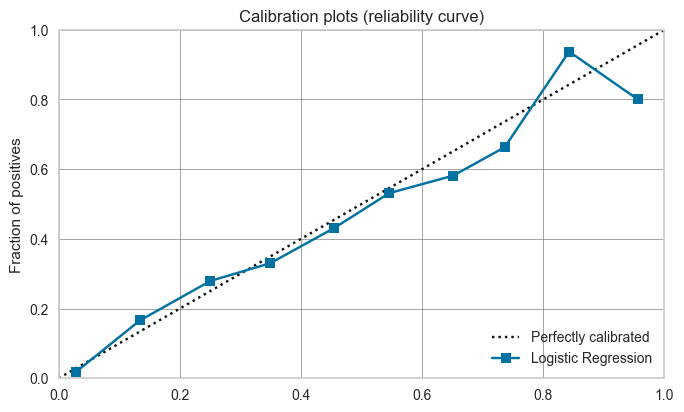

In [99]:
pyc.plot_model(lr_tuned_calibrated_iso, plot='calibration')

<a id="" ></a>

<h1>  Model Interpretation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.interpret_model(
    estimator,
    plot           = 'summary',
    feature        = None,
    observation    = None,
    use_train_data = False,
    **kwargs,
)
```

In [100]:
# pyc.interpret_model?

In [102]:
# interpret_model: SHAP
# pyc.interpret_model(model_best_lr)

# note: logistic regression is not supported
# supported: rf, xgboost, lightgbm, catboost, dt, et

In [104]:
# interpret model : Correlation
# pyc.interpret_model(model_best_lr,plot='correlation')

In [105]:
# interpret model : Reason
# pyc.interpret_model(model_best_lr,plot='reason',obervation=12)

<a id="" ></a>

<h1>  Model Prediction </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.predict_model(
    estimator,
    data                  = None,
    probability_threshold = None,
    encoded_labels        = False,
    round                 = 4,
    verbose               = True,
) -> pandas.core.frame.DataFrame
```

In [106]:
# pyc.predict_model?

In [107]:
df_test.iloc[:5,-5:]

,Contract_totCharges_diff,PayMeth_mean_monthCharges,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat
0,-1313.937095,67.437658,-18.837658,0,0
1,1902.661398,67.437658,32.462342,4,0
2,1880.912905,63.914865,40.285135,2,0
3,-3545.288602,63.914865,-44.214865,1,0
4,-3415.038602,67.437658,-47.387658,1,0


In [108]:
df_preds = pyc.predict_model(model_best_lr,df_test)
df_preds.iloc[:5,-5:]

,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat,Label,Score
0,-18.837658,0,0,1,0.5631
1,32.462342,4,0,0,0.8124
2,40.285135,2,0,1,0.6904
3,-44.214865,1,0,0,0.9601
4,-47.387658,1,0,0,0.9648


<a id="" ></a>

<h1>  Model Persistence </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.save_model(
    model,
    model_name,
    model_only = False,
    verbose    = True,
)
```

In [111]:
# pyc.save_model?

In [109]:
if 'google.colab' in sys.modules:
    h = ''
else:
    h = "../models/"

In [112]:
# save the model
path_model = h + 'model_best_lr_pycaret.pkl'
pyc.save_model(model_best_lr, path_model)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Churn',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strat...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=2.039, class_weight='balanced',
                     

In [113]:
# load model
model_best_lr = pyc.load_model(model_name=path_model)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
# save entire experiment
# pyc.save_experiment( h + "experiment_may31_2020")
# saved_experiment = pyc.load_experiment( h+ 'experiment_may31_2020')

<a id="" ></a>

<h1>  Finalize model (Fit whole train data) </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

```python
pyc.finalize_model(
    estimator,
    fit_kwargs = None,
    group      = None,
    model_only = True,
)

Docstring:
This function trains a given estimator on the entire dataset including the 
holdout set.
```

In [119]:
# pyc.finalize_model?

In [120]:
# final_lr = pyc.finalize_model(model_best_lr)
# print(final_lr)

# for some reason this fails

<a id="" ></a>

<h1>  Model Evaluation on Test Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [123]:
df_preds = pyc.predict_model(model_best_lr,df_test)
df_preds.iloc[-5:,-5:]

,PayMeth_monthCharges_diff,Tenure_cat,MonthlyCharges_cat,Label,Score
1404,16.585135,0,0,1,0.8082
1405,-19.764865,3,0,0,0.7792
1406,6.085135,1,0,1,0.7244
1407,30.735135,1,0,1,0.8700
1408,-2.787658,1,0,0,0.5359


In [124]:
ytest = df_preds[target_name].to_numpy().ravel()
ypreds = df_preds['Label'].to_numpy().ravel()

In [125]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: ', accuracy_score(ytest,ypreds))
print('Precision: ', precision_score(ytest,ypreds))
print('Recall: ', recall_score(ytest,ypreds))
print('F1-score: ', f1_score(ytest,ypreds))


Accuracy:  0.7437899219304471
Precision:  0.5109612141652614
Recall:  0.8101604278074866
F1-score:  0.626680455015512


In [126]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [127]:
print(classification_report(ytest,ypreds))
# look at the value of recall for 1. It must be nearer to 1.

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.81      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.81      0.74      0.76      1409



In [128]:
confusion_matrix(ytest,ypreds)

array([[745, 290],
       [ 71, 303]])

In [129]:
df_preds[target_name].value_counts()

0    1035
1     374
Name: Churn, dtype: int64

In [130]:
df_preds[target_name].value_counts(normalize=True)

0    0.734564
1    0.265436
Name: Churn, dtype: float64

In [131]:
"""
There are total  374 churn cases in test dataset (20% of full data with seed=100)
Out of which only 303 are correctly classified.

This is great an improvement.
The dataset it highly imbalanced. The dumb classifier will classify
everything as non-churn.
""";

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [132]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 4 hr 8 min 18 secs
